## Measuring rotation in Psc-Eri

[Curtis et al. (2019)](https://arxiv.org/pdf/1905.10588.pdf) measured rotation for the Meingast et al. (2019) members o the Psc-Eri stellar stream, and found a clear co-eval structure in rotation-colour space.

Here, we will attempt to recover that same co-eval structure in the 101 stars targeted in that study, using `michael` only.

In [4]:
import sys
sys.path.insert(0, "../")

from michael import janet
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
cmap = sns.color_palette('colorblind', 8)

from jax import random
rng = random.PRNGKey(53)

from astroquery.vizier import Vizier
from astropy.coordinates import Angle
from astropy import units as u

import warnings
warnings.filterwarnings('ignore')

Hi there. Welcome to the good place.


In [5]:
cat = Vizier(catalog ='J/AJ/158/77/table2',
       columns = ['Source', 'RA_ICRS', 'DE_ICRS', 'GBP-GRP', 'Teff', 'Gmag','GMag', 'Prot'])
cat.ROW_LIMIT = -1
psceri_full = cat.get_catalogs(cat.catalog)[0]

In [24]:
from tqdm import tqdm

N = len(psceri_full)

df = pd.DataFrame(index = range(N), columns=['P', 'Perr', 'Pflag'])

for idx in tqdm(range(N)):
    psceri = psceri_full[idx]
    source = psceri['Source']

    ra_str = psceri['RA_ICRS'].split(' ')
    units_ra = ['h','m','s']
    rep = ''.join([ra_str[i]+units_ra[i] for i in range(3)])
    ra = Angle(rep).to(u.deg)

    dec_str = psceri['DE_ICRS'].split(' ')
    units_dec = ['d','m','s']
    rep = ''.join([dec_str[i]+units_dec[i] for i in range(3)])
    dec = Angle(rep).to(u.deg)

    j = janet(source, ra, dec,
              output_path = "/Users/oliver hall/Research/michael/Examples/PscEri",
              verbose = True)
    
    j.run(period_range = (psceri['Prot'].min()*0.5, 
                              psceri['Prot'].max()*1.5))

    
    df.loc[idx, 'P']= j.results.loc['best', 'overall']
    df.loc[idx, 'Perr']= j.results.loc['best', 'e_overall']
    df.loc[idx, 'Pflag']= j.results.loc['best', 'f_overall']
df['PC'] = np.array(psceri_full['Prot'].data)
df.to_csv('PscEri/PscEri_periods.csv')

  0%|                                                   | 0/101 [00:00<?, ?it/s]

Already have data downloaded for Gaia ID 3198972700981234048.
If you want to check for new data, run `janet.update()`.
No postcard object will be created for this target.
### Running Simple Astropy Lomb-Scargle on Sector all on star 3198972700981234048 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 3198972700981234048 ###
### Saved results ###
### Running Wavelet Estimation for Sector all on star 3198972700981234048 ###


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|                                                   | 0/101 [00:02<?, ?it/s]

### Completed Wavelet Estimation for Sector all on star 3198972700981234048 ###
### Saved results ###
### Running Composite ACF estimation for Sector all on star 3198972700981234048 ###
### Completed Composite ACF estimation for Sector all on star 3198972700981234048 ###
### Saved results ###
### Running ACF Estimation on star 3198972700981234048 ###


KeyError: 'clc_5'

In [26]:
list(j.void)

['datum_5',
 'clc_all',
 'pg_all',
 'p_all',
 'P_all',
 'popt_all',
 'all_wt',
 'all_wwz',
 'all_wwa',
 'all_wavelet_popt',
 'all_vizacf',
 'all_cacf',
 'all_cacfsmoo',
 'all_cpeaks',
 'all_cacf_popt']

In [22]:
list(np.array([j.sectors]))

[array([ 2,  3, 29, 30])]

In [8]:
df = pd.read_csv('PscEri/PscEri_periods.csv', index_col=0)
df.head(5)

,P,Perr,Pflag,PC
0,NaN,NaN,NaN,0.52
1,0.834207,0.008747,129.0,0.87
2,0.836451,0.036538,129.0,0.82
3,NaN,NaN,NaN,0.56
4,0.944861,0.012928,129.0,0.94


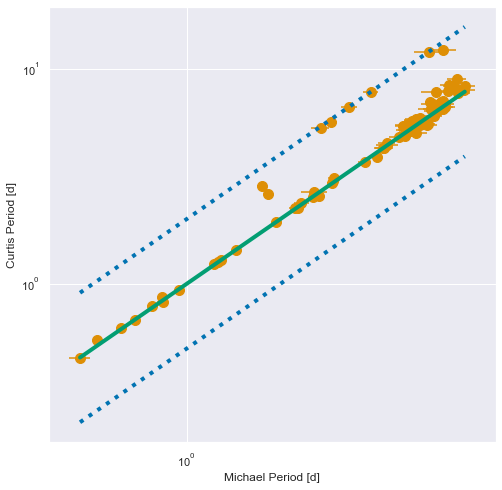

In [9]:
sns.set_style('darkgrid')
cmap = sns.color_palette('colorblind', 8)

s = df.Pflag <= 256

fig = plt.figure(figsize=(8,8))
plt.scatter(df.P[s], psceri_full['Prot'][s], s=100, c=cmap[1])
plt.errorbar(df.P[s], psceri_full['Prot'][s], xerr=df.Perr[s], fmt='|', zorder=0, c=cmap[1])

x = np.linspace(df.P.min(), df.P.max())
plt.plot(x, 2*x, ls=':', lw=4, c=cmap[0])
plt.plot(x, 0.5*x, ls=':', lw=4, c= cmap[0])
plt.plot(x, x, lw=4, c=cmap[2])

plt.xlabel('Michael Period [d]')
plt.ylabel('Curtis Period [d]')
plt.yscale('log')
plt.xscale('log')

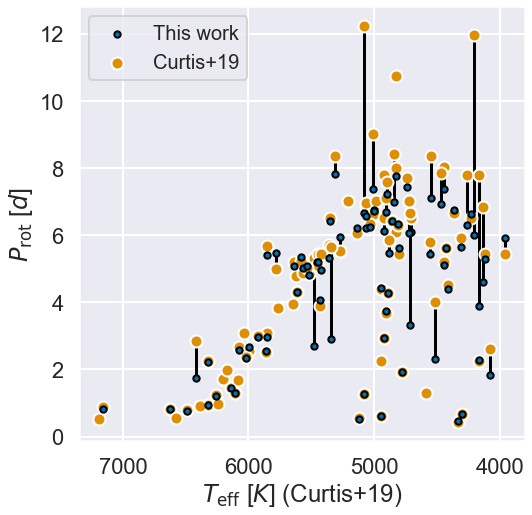

In [10]:
sns.set_context('poster')
cmap = sns.color_palette('colorblind', 8)
fig = plt.figure(figsize=(8,8))
plt.scatter(psceri_full['Teff'], df.P, zorder=3, s=40, c=cmap[0], ec='k',
           label = 'This work')
plt.scatter(psceri_full['Teff'], psceri_full['Prot'], zorder=2, ec='w', c=cmap[1],
           label = 'Curtis+19')
for idx in range(len(df)):
    plt.vlines(psceri_full[idx]['Teff'], 
                ymin = np.min([df.loc[idx, 'P'], psceri_full[idx]['Prot']]),
                ymax = np.max([df.loc[idx, 'P'], psceri_full[idx]['Prot']]),
                color= 'k', zorder=1)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'$T_{\rm eff}$ [$K$] (Curtis+19)')
plt.ylabel(r'$P_{\rm rot}$ [$d$]')
plt.grid(zorder=0)


In [11]:
s = np.abs(df.P.values - psceri_full['Prot']) < df.Perr.values

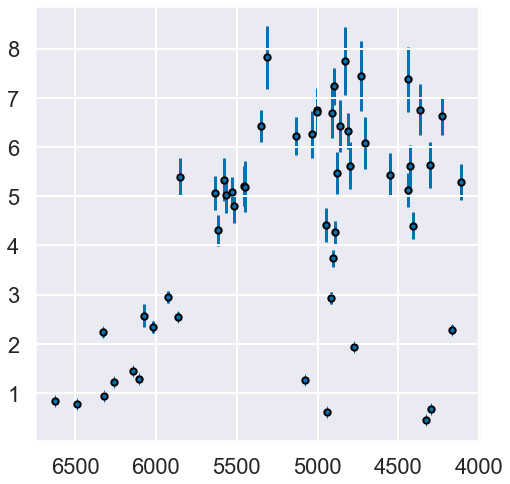

In [12]:
fig = plt.figure(figsize=(8,8))
plt.scatter(psceri_full[s]['Teff'], df[s]['P'], zorder=3, s=40, c=cmap[0], ec='k',
           label = 'This work')
plt.errorbar(psceri_full[s]['Teff'], df[s]['P'], zorder=0, fmt='|',
           yerr = df[s]['Perr'])
plt.gca().invert_xaxis()

Which stars do ont fall within 1 sigma of the curtis targets?

In [13]:
s = np.abs(df.P.values - psceri_full['Prot']) < 1*df.Perr.values
dfs = df[~s].reset_index()

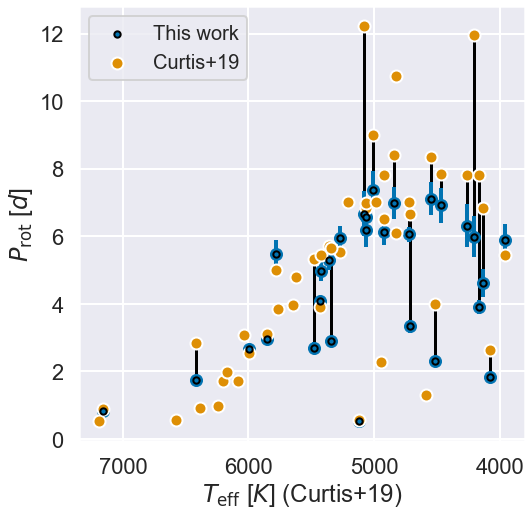

In [14]:
sns.set_context('poster')
cmap = sns.color_palette('colorblind', 8)
fig = plt.figure(figsize=(8,8))
plt.scatter(psceri_full[~s]['Teff'], dfs.P, zorder=4, s=40, c=cmap[0], ec='k',
           label = 'This work')
plt.scatter(psceri_full[~s]['Teff'], psceri_full[~s]['Prot'], zorder=3, ec='w', c=cmap[1],
           label = 'Curtis+19')
plt.errorbar(psceri_full[~s]['Teff'], dfs.P, yerr=dfs.Perr, fmt='o', barsabove=True, 
             elinewidth=4, zorder=2)
for idx in range(len(df[~s])):
    plt.vlines(psceri_full[~s][idx]['Teff'], 
                ymin = np.min([dfs.loc[idx, 'P'], psceri_full[~s][idx]['Prot']]),
                ymax = np.max([dfs.loc[idx, 'P'], psceri_full[~s][idx]['Prot']]),
                color= 'k', zorder=1)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'$T_{\rm eff}$ [$K$] (Curtis+19)')
plt.ylabel(r'$P_{\rm rot}$ [$d$]')
plt.grid(zorder=0)


In [15]:
dfs

,index,P,Perr,Pflag,PC
0,0,NaN,NaN,NaN,0.52
1,1,0.834207,0.008747,129.0,0.87
2,3,NaN,NaN,NaN,0.56
3,7,NaN,NaN,NaN,1.71
4,8,NaN,NaN,NaN,0.91
5,9,NaN,NaN,NaN,0.97
6,10,NaN,NaN,NaN,1.97
7,14,NaN,NaN,NaN,1.70
8,16,NaN,NaN,NaN,3.08
9,17,2.666641,0.089824,129.0,2.55


In [16]:
psceri_full[~s].to_pandas().to_csv('psceri_disagreement.csv')

In [17]:
psceri_full[~s].to_pandas()

,Source,RA_ICRS,DE_ICRS,GBP-GRP,Teff,Gmag,GMag,Prot
0,3198972700981234048,04 22 31.5,-07 33 03.2,0.432,7187,8.903,2.802,0.52
1,5181474045115843072,03 10 47.3,-06 34 29.8,0.446,7161,8.562,2.954,0.87
2,3245408684793798528,04 02 15.4,-05 53 48.2,0.604,6573,9.425,3.513,0.56
3,3186195241994234880,04 43 02.6,-07 53 54.5,0.655,6206,9.999,3.766,1.71
4,2988096919213031808,05 02 35.2,-12 31 20.4,0.661,6387,10.280,3.869,0.91
5,2987729922847457280,05 07 09.2,-13 34 07.7,0.668,6240,10.156,3.896,0.97
6,3204844780267292288,04 29 21.6,-02 49 47.1,0.673,6173,9.760,4.020,1.97
7,2982998926174605824,05 10 30.1,-16 08 04.1,0.691,6081,10.646,3.970,1.70
8,3256702490277205376,04 03 24.9,-00 46 45.2,0.701,6033,9.928,4.180,3.08
9,5104477754084350464,03 15 18.8,-17 56 36.4,0.731,5993,9.606,4.279,2.55
